## [0단계] 사용할 라이브러리와 패키지 불러오기


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

## [1단계] 데이터 불러오기 및 feature 생성

In [ ]:
df = pd.read_csv("../data/merged/traffic_weather_features.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()

# 1) 기본 통계
features = df.groupby("intersection").agg(
    mean_volume=("traffic_volume", "mean"),
    std_volume=("traffic_volume", "std")
).reset_index()

# 2) 출근 피크 (7~9시)
morning = df[df['hour'].between(7,9)].groupby("intersection")["traffic_volume"].mean()
features["peak_morning"] = features["intersection"].map(morning)

# 3) 퇴근 피크 (17~19시)
evening = df[df['hour'].between(17,19)].groupby("intersection")["traffic_volume"].mean()
features["peak_evening"] = features["intersection"].map(evening)

# 4) 주말/공휴일 비율
weekend = df[df['is_offday']==1].groupby("intersection")["traffic_volume"].mean()
weekday = df[df['is_offday']==0].groupby("intersection")["traffic_volume"].mean()

features["weekend_ratio"] = features["intersection"].apply(
    lambda x: weekend.get(x, np.nan) / weekday.get(x, np.nan)
)

# 5) 기상 민감도 (비O vs 비X)
rain = df[df['is_rain']==1].groupby("intersection")["traffic_volume"].mean()
norain = df[df['is_rain']==0].groupby("intersection")["traffic_volume"].mean()

features["rain_effect"] = features["intersection"].apply(
    lambda x: rain.get(x, np.nan) / norain.get(x, np.nan)
)

# 6) 바람과 교통량 상관관계
wind_corr = df.groupby("intersection")[["wind","traffic_volume"]].corr().iloc[0::2, -1].reset_index()
wind_corr = wind_corr.rename(columns={"traffic_volume": "wind_corr"})
features["wind_corr"] = features["intersection"].map(
    wind_corr.set_index("intersection")["wind_corr"]
)

features.head()

## [2단계] 모델 구성하기

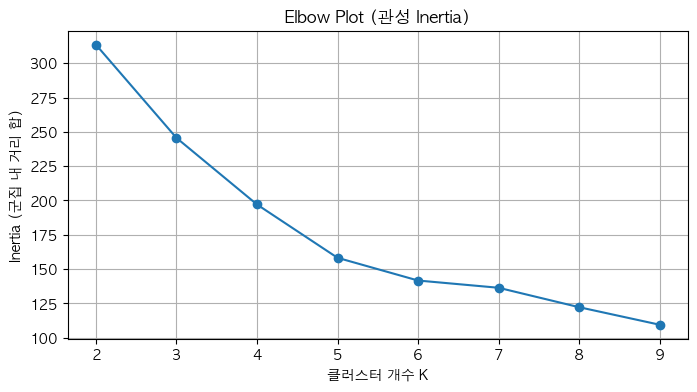

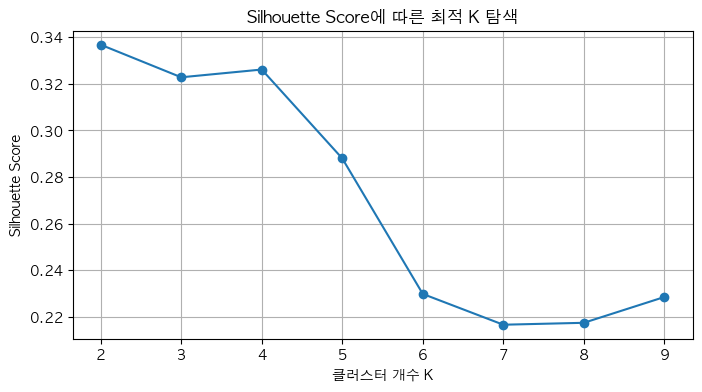


📌 추천되는 최적 K값: 2


In [ ]:
# ============================================================
# [1단계] 스케일링 + Elbow Plot + Silhouette Score
# ============================================================



# 한글 폰트
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

# -------------------------
# 1) intersection 제외한 feature만 사용
# -------------------------
X = features.drop(columns=["intersection"]).copy() # 문자열인 intersection은 숫자 feature과 분리

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 2) Elbow Method
# -------------------------
inertias = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Plot (관성 Inertia)")
plt.xlabel("클러스터 개수 K")
plt.ylabel("Inertia (군집 내 거리 합)")
plt.grid(True)
plt.show()

# -------------------------
# 3) Silhouette Score
# -------------------------
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score에 따른 최적 K 탐색")
plt.xlabel("클러스터 개수 K")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# -------------------------
# 4) 가장 좋은 K 추천
# -------------------------
best_k = K_range[sil_scores.index(max(sil_scores))]
print(f"\n📌 추천되는 최적 K값: {best_k}")

In [1]:
# ============================================================
# [2단계] KMeans 클러스터링
# ============================================================

from sklearn.cluster import KMeans

# 클러스터 개수 (이전 단계에서 2로 결정됨)
k = 2

# KMeans 모델 생성 및 학습
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
features["cluster"] = kmeans.fit_predict(X_scaled)

# 결과 확인
features.head(10)

# 클러스터링 결과 저장
output_path = "../data/merged/cluster_features.csv"
features.to_csv(output_path, index=False, encoding="utf-8-sig")
print("✔ 클러스터링 포함 features 파일 저장 완료 →", output_path)
print("컬럼 목록:", list(features.columns))



NameError: name 'X_scaled' is not defined

In [5]:
# ============================================================
# [3단계] 클러스터 해석 + 상시혼잡형 추출 코드
# ============================================================
import pandas as pd

# 클러스터별 평균 특성 요약
cluster_summary = features.groupby("cluster").mean(numeric_only=True)

# 상시혼잡형 자동 선택 기준:
# "mean_volume" (평균 교통량)가 가장 높은 클러스터를 상시혼잡형으로 정의
congested_cluster = cluster_summary["mean_volume"].idxmax()
print("🔴 상시혼잡형으로 판단된 클러스터 번호:", congested_cluster)

# 해당 클러스터(상시혼잡형)에 속한 교차로 리스트 출력
congested_intersections = features[features["cluster"] == congested_cluster]["intersection"]
congested_intersections = congested_intersections.sort_values().reset_index(drop=True)

print("\n🚦 상시혼잡형 교차로 목록:")
for name in congested_intersections:
    print("-", name)



🔴 상시혼잡형으로 판단된 클러스터 번호: 1

🚦 상시혼잡형 교차로 목록:
- 고재4
- 구성3
- 굴울(변전소)4
- 남부5
- 도로원점3
- 두정역사거리
- 방아다리(이마트)4
- 백석사거리
- 백석충전소사거리
- 번영로(갤러리아)4
- 불당4
- 불당현대4
- 삼성전관3
- 새말(한라APT입구)4
- 서부대로사거리
- 성정롯데4
- 시청4
- 쌍용도서관3
- 쌍용동4
- 쌍용초교4
- 여성회관4
- 용암4
- 원형육교4
- 이수(3산업)4
- 인쇄창4
- 일봉산4
- 천안대로4
- 청당동입구4
- 청삼4
- 하신3
- 한들사거리


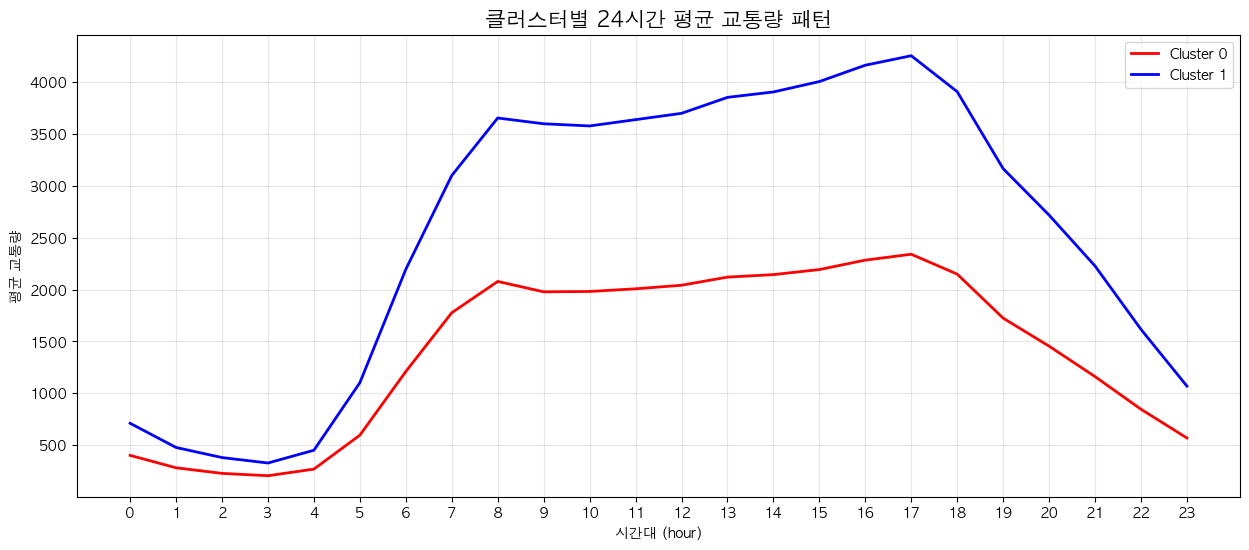

In [6]:
# ============================================================
# [4단계] 클러스터 결과 시각화 (24시간 패턴 비교)
# ============================================================

import matplotlib.pyplot as plt

# datetime → hour만 있으면 됨
df['hour'] = df['datetime'].dt.hour

# merge: df + 클러스터 결과(features)
df_clustered = df.merge(features[['intersection', 'cluster']], on='intersection', how='left')

# 클러스터별 색깔
colors = ['red', 'blue']

plt.figure(figsize=(15,6))

for c in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == c]
    
    hourly_mean = cluster_data.groupby('hour')['traffic_volume'].mean()

    plt.plot(hourly_mean.index,
             hourly_mean.values,
             label=f"Cluster {c}", # Cluster 0: 중/저혼잡형, 1: 상시혼잡형
             linewidth=2,
             color=colors[c % len(colors)]
    )

plt.title("클러스터별 24시간 평균 교통량 패턴", fontsize=15)
plt.xlabel("시간대 (hour)")
plt.ylabel("평균 교통량")
plt.xticks(range(24))
plt.grid(alpha=0.3)
plt.legend()
plt.show()
